# Topic Modeling Lab
## Contents
1. [Setup](#Section-1%3A-Setup)
    1. [Import](#1.1-Import-Packages)
    1. [Download](#1.2-Download-and-Prepare-Data)
    1. [Read](#1.3-Read-Data)
    1. [Pick Your Data](#1.4-Pick-Your-Data)
    1. [Clean Text](#1.5-Clean-Text)
1. [Converting Text to Numbers](#Section-2%3A-Converting-Text-to-Numbers)
1. [LDA Topic Model](#Section-3%3A-LDA-Topic-Model)
1. [Interpret Topics](#Section-4%3A-Interpret-Topics)
1. [Topic Quality](#Section-5%3A-Topic-Quality)
1. [Topic Popularity](#Section-6%3A-Topic-Popularity)
1. [NMF Topic Model](#Section-7%3A-NMF-Topic-Model)
1. [What We Learned](#Section-7%3A-What-We-Learned)

## Section 0: Background
- In this lab, we'll learn about topic modeling. Topic modeling uses statistics to understand what text is about, that is, to find the topics in text.
- We'll use the online dating profile text that OKCupid made public as our example, but of course topic modeling can be used on any text.

@Author: [Jeff Lockhart](http://www-personal.umich.edu/~jwlock/) & [Ed Platt](https://elplatt.com/), with some code adapted from [Aneesha Bakharia](https://medium.com/@aneesha/topic-modeling-with-scikit-learn-e80d33668730)'s example.

## Section 1: Setup
### 1.1 Import Packages
- Packages contain code others have written to make our work easier.

In [1]:
!pip install lxml
!pip install spacy
!pip install gensim
!pip install nltk
!pip install tqdm
!pip install pyLDAvis
!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 10.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.0 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached murmurhash-1.0.10-cp311-cp311-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metadata (2.0 kB)
  Using cached cymem-2.0.8-cp311-cp311-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metadata (8.4 kB)
  Using cached preshed-3.0.9-cp311-cp311-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metadata (2.2 kB)
  Using cached thinc-8.2.5-cp311-cp311-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metadata (15 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached srsly-2.4.8-cp311-cp311-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metadata (20 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached pydantic-2.9.

In [2]:
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

from tqdm import tqdm
tqdm.pandas()

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from bs4 import BeautifulSoup
import spacy

import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.corpora as corpora

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from sklearn.metrics.pairwise import cosine_similarity

import time

%matplotlib inline


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 1.2 Download and Prepare Data
This code checks whether you have the data. If you don't, it will download and prepare it for you. To see how it works, look at lab `1 Data munging` which explains it in detail.

In [3]:
%run -i "download_and_clean_data.py"
print('Ready to go!')

Ready to go!


### 1.3 Read Data

In [4]:
profiles = pd.read_csv('data/clean_profiles.tsv', sep='\t')
profiles.head(2)

,age_group,age,body,alcohol_use,drug_use,edu,race_ethnicity,height_group,industry,kids,...,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,20,22,overweight,yes,no,HS,multiple,over_6,other,no,...,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...","books:<br />\nabsurdistan, the republic, of mi...",food.<br />\nwater.<br />\ncell phone.<br />\n...,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet!<br />\nyou...
1,30,35,average,yes,yes,unknown,White,under_6,other,no,...,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories.<br /...,NaN,NaN,i am very open and will share just about anyth...,NaN


### 1.4 Pick Your Data
- Pick which section of the profiles you want to analyze.
#### Options:
- `text` - All of the text from a profile (**Recommended**)
- `essay0` - My self summary (**Recommended**)
- `essay1` - What I’m doing with my life
- `essay2` - I’m really good at
- `essay3` - The first thing people usually notice about me
- `essay4` - Favorite books, movies, show, music, and food
- `essay5` - The six things I could never do without
- `essay6` - I spend a lot of time thinking about
- `essay7` - On a typical Friday night I am
- `essay8` - The most private thing I am willing to admit
- `essay9` - You should message me if...

#### Replace `essay0` in the cell below with the essay you want to look at.
- `text` and `essay0` are both recommended, but it's your choice.

In [5]:
profile_section_to_use = 'essay0'

### 1.5 Clean Text 
- For this lab, it is not so important that you understand this code. 
- For now, just run it and move on. 

In [6]:
# Some of the essays have just a link in the text. BeautifulSoup sees that and gets 
# the wrong idea. This line hides those warnings.
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
warnings.filterwarnings("ignore", category=DeprecationWarning, module='bs4.builder._lxml')
def clean(text):
    if pd.isnull(text):
        t = np.nan
    else:
        t = BeautifulSoup(text, 'lxml').get_text()
        t = t.lower()

        bad_words = ['http', 'www', '\nnan']

        for b in bad_words:
            t = t.replace(b, '')
    if t == '':
        t = np.nan
    
    return t

In [7]:
print('Cleaning up profile text for', profile_section_to_use, '...')
profiles['clean'] = profiles[profile_section_to_use].progress_apply(clean)

print('We started with', profiles.shape[0], 'profiles.')
print("Dropping profiles that didn't write anything for the essay we chose...")
profiles.dropna(axis=0, subset=['clean'], inplace=True)

text_cols = ['text', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 
             'essay5', 'essay6', 'essay7', 'essay8', 'essay9']
profiles.drop(columns=text_cols, inplace=True)

#what we will use as our documents, here the cleaned up text of each profile
documents = profiles['clean'].values

print('We have', documents.shape[0], 'profiles left.')

Cleaning up profile text for essay0 ...


  0%|          | 0/58785 [00:00<?, ?it/s]/tmp/ipykernel_423/512017477.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  t = BeautifulSoup(text, 'lxml').get_text()
/tmp/ipykernel_423/512017477.py:9: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  t = BeautifulSoup(text, 'lxml').get_text()
100%|██████████| 58785/58785 [00:04<00:00, 11941.73it/s]

We started with 58785 profiles.
Dropping profiles that didn't write anything for the essay we chose...
We have 53396 profiles left.


#### Remove punctuation/lower casing

- Next, let’s perform a simple preprocessing on the content of paper_text column to make them more amenable for analysis, and reliable results.
- To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text

In [8]:
# Load the regular expression library

# Remove punctuation
profiles['clean'] = profiles['clean'].map(lambda x: re.sub(r'[,.!?]', '', x))

# Convert the text to lowercase
profiles['clean'] = profiles['clean'].map(lambda x: x.lower())

# Print out the first rows of profiles
profiles['clean'].head()



0    about me:\n\ni would love to think that i was ...
1    i am a chef: this is what that means\n1 i am a...
2    i'm not ashamed of much but writing public tex...
3               i work in a library and go to school  
4    hey how's it going currently vague on the prof...
Name: clean, dtype: object

## Section 2: Converting Text to Numbers

** **
#### Step 1: Tokenize words and further clean-up text
** **
Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

- Here we tell it to only use the 1,000 most popular words, ignoring stop words like "a" and "of".

In [9]:
# [:1] selects the first profile, and [:30] selects the first 30 words from that profile
# You can try to change the parameters and see what happens
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data = profiles.clean.values.tolist()
data_words = list(sent_to_words(data))

print("The first 30 cleaned words of essay 0 from profile 0 are:\n\n", data_words[:1][0][:30])

The first 30 cleaned words of essay 0 from profile 0 are:

 ['about', 'me', 'would', 'love', 'to', 'think', 'that', 'was', 'some', 'some', 'kind', 'of', 'intellectual', 'either', 'the', 'dumbest', 'smart', 'guy', 'or', 'the', 'smartest', 'dumb', 'guy', 'can', 'say', 'can', 'tell', 'the', 'difference', 'love']


** **
#### Step 2: Remove Stopwords, Make Bigrams and Lemmatize
** **

The phrase models are ready. Let’s define the functions to remove the stopwords, make trigrams and lemmatization and call them sequentially.

<div class="alert-info">
 
#### Short Answer No.1
- (1) Why do we want to ignore stop words? (1-2 sentences)
- (2) Give 3 more examples of stop words 
    
    
</div>

🤔 **Write your response here:**
...



In [10]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

** **
#### Step 3: Phrase Modeling: Bigram and Trigram Models
** **

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring. Some examples in our example are: 'back_bumper', 'oil_leakage', 'maryland_college_park' etc.

Gensim's Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold.

*The higher the values of these param, the harder it is for words to be combined.*

In [12]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#### See what words are being counted

In [13]:
# Define functions for bigrams, trigrams and lemmatization

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Let's call the functions in order. Note that calling these functions might take a couple of time, generally around 2 minutes.

In [18]:
start_time = time.time()

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print("The first 30 words of essay 0 from profile 0 (after lemmatization) are:\n\n", data_lemmatized[:1][0][:30])

print("--- %s seconds ---" % (time.time() - start_time))

The first 30 words of essay 0 from profile 0 (after lemmatization) are:

 ['love', 'think', 'kind', 'intellectual', 'dumbest', 'smart', 'guy', 'smart', 'dumb', 'guy', 'say', 'tell', 'difference', 'love', 'talk', 'idea', 'concept', 'forge', 'odd', 'metaphor', 'instead', 'recite', 'cliche', 'simularitie', 'underwater', 'salt', 'favorite', 'word', 'salt', 'way']
--- 128.3054177761078 seconds ---


#### See an example of how a profile's text is encoded
- `n` is the profile number you want to look at. Change the value of `n` and re-run the code to see different profiles.

In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1][0][:30])

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1)]


In [20]:
def show_bow_vector(bow, dictionary):
    for word_id, count in bow:
        print(f"{dictionary[word_id]} \t {count}")

# Assuming you want to show the n-th document
n = 6
print(f"Profile text:\n{documents[n]}\n")

print("\nBOW (Bag-of-Words) vector:")
show_bow_vector(corpus[n], id2word)


Profile text:
life is about the little things. i love to laugh. it's easy to do
when one can find beauty and humor in the ugly. this perspective
makes for a more gratifying life. it's a gift. we are here to play.


BOW (Bag-of-Words) vector:
laugh 	 1
life 	 2
little 	 1
love 	 1
make 	 1
thing 	 1
find 	 1
beauty 	 1
easy 	 1
gift 	 1
gratifying 	 1
humor 	 1
perspective 	 1
play 	 1
ugly 	 1


<div class="alert-info">
    
#### Short Answer No.2 

- (1) Given the essay questions decribed above, list 5 words that you predict to be the most popular in essay4. 
    
    
</div>

🤔 **Write your response here:**
...



In [21]:
profile_section_to_use = 'essay4'

In [23]:
# In this cell, let's find the top 10 most popular words and list them alphabetically. 
# Look the sample codes above and try fill in the "???".
# This would generally take around 140 seconds.
start_time = time.time()

profiles = pd.read_csv('data/clean_profiles.tsv', sep='\t')

print('Cleaning up profile text for', profile_section_to_use, '...')
profiles['clean'] = profiles[profile_section_to_use].progress_apply(clean)

print('We started with', profiles.shape[0], 'profiles.')
print("Dropping profiles that didn't write anything for the essay we chose...")
profiles.dropna(axis=0, subset=['clean'], inplace=True)

# Remove unused text columns
text_cols = ['text', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 
             'essay5', 'essay6', 'essay7', 'essay8', 'essay9']
profiles.drop(columns=text_cols, inplace=True)

# Documents we will work with (cleaned text)
documents = profiles['clean'].values

# Split each document into tokens (list of words) for Gensim
data_words = [doc.split() for doc in documents]
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Create a Gensim dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Filter out words that occur in less than 10 documents, or more than 50% of documents
id2word.filter_extremes(no_below=10, no_above=0.5)

texts = data_lemmatized

corpus = ???

# Print the total number of rows and columns (dictionary size)
print(f"Our transformed text has {len(corpus)} rows and {len(corpus)} columns.")

print("The first few words (after lemmatization) are:\n", list(id2word.token2id.keys())[:20])

print("--- %s seconds ---" % (time.time() - start_time))

Cleaning up profile text for essay4 ...


  0%|          | 0/58785 [00:00<?, ?it/s]/tmp/ipykernel_423/512017477.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  t = BeautifulSoup(text, 'lxml').get_text()
  3%|▎         | 2038/58785 [00:00<00:05, 10203.88it/s]/tmp/ipykernel_423/512017477.py:9: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  t = BeautifulSoup(text, 'lxml').get_text()
100%|██████████| 58785/58785 [00:05<00:00, 10817.17it/s]


We started with 58785 profiles.
Dropping profiles that didn't write anything for the essay we chose...
Our transformed text has 48432 rows and 48432 columns.
The first few words (after lemmatization) are:
 ['aesop', 'cry', 'feel', 'game', 'hail', 'make', 'man', 'operation', 'rock', 'show', 'throne', 'want', 'alternative', 'die', 'draw', 'fan', 'hard', 'humor', 'involve', 'kind']
--- 137.46600794792175 seconds ---


<div class="alert-info">
    
- (2) Did any of your predicted words made to top 10? (No right or wrong answer!) 
    
</div>

🤔 **Write your response here:**
...



In [24]:
# Now let's focus on essay0 again. 
# This would take another 140 seconds.

profile_section_to_use = 'essay0'

profiles = pd.read_csv('data/clean_profiles.tsv', sep='\t')

print('Cleaning up profile text for', profile_section_to_use, '...')
profiles['clean'] = profiles[profile_section_to_use].progress_apply(clean)

print('We started with', profiles.shape[0], 'profiles.')
print("Dropping profiles that didn't write anything for the essay we chose...")
profiles.dropna(axis=0, subset=['clean'], inplace=True)

# Remove unused text columns
text_cols = ['text', 'essay0', 'essay1', 'essay2', 'essay3', 'essay4', 
             'essay5', 'essay6', 'essay7', 'essay8', 'essay9']
profiles.drop(columns=text_cols, inplace=True)

# Documents we will work with (cleaned text)
documents = profiles['clean'].values

# Split each document into tokens (list of words) for Gensim
data_words = [doc.split() for doc in documents]
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Create a Gensim dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Filter out words that occur in less than 10 documents, or more than 50% of documents
id2word.filter_extremes(no_below=10, no_above=0.5)

texts = data_lemmatized

#corpus = ???
corpus = [id2word.doc2bow(text) for text in texts]

# Print the total number of rows and columns (dictionary size)
print(f"Our transformed text has {len(corpus)} rows and {len(corpus)} columns.")

print("The first few words (after lemmatization) are:\n", list(id2word.token2id.keys())[:20])

Cleaning up profile text for essay0 ...


  0%|          | 0/58785 [00:00<?, ?it/s]/tmp/ipykernel_423/512017477.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  t = BeautifulSoup(text, 'lxml').get_text()
/tmp/ipykernel_423/512017477.py:9: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  t = BeautifulSoup(text, 'lxml').get_text()
100%|██████████| 58785/58785 [00:04<00:00, 12248.71it/s]


We started with 58785 profiles.
Dropping profiles that didn't write anything for the essay we chose...
Our transformed text has 53396 rows and 53396 columns.
The first few words (after lemmatization) are:
 ['able', 'attention_span', 'bend', 'blow', 'choice', 'cliche', 'concept', 'consider', 'conversation', 'cool', 'decide', 'deep', 'difference', 'dress', 'dumb', 'everyday', 'extra_point', 'favorite', 'forge', 'funny']


## Section 3: LDA Topic Model

- LDA stands for Latent Dirichlet Allocation. The statistical math behind it is complicated, but its goals are simple:
    - find groups of words that often show up together and call those groups topics. 
    - find topics that can be used to tell documents apart, i.e. topics that are in some documents but not others.
- LDA is the most popular method for topic modeling.
- [Learn more](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) about LDA

### Step 1: Decide how many topics we want to find

<div class="alert-info">
    
#### Short Answer No.3
- How would the number of topics you choose affect the result in your opinion? (Think about extreme cases like you only pick 1 topic, vs if you pick 10,000 topics.) (1-2 sentences)
- Choose 1 essay and describe the types of topics you would expect to find.
    
</div>

🤔 **Write your response here:**
...



In [27]:
#how many topics we want our model to find
ntopics = 15
nshow = 10

### Step 2: Run the LDA algorithm
- LDA can be a little slow. We'll use a faster method later on.
- We have everything required to train the base LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well. Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior (we'll use default for the base model).
- chunksize controls how many documents are processed at a time in the training algorithm. Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.
- passes controls how often we train the model on the entire corpus (set to 10). Another word for passes might be "epochs". iterations is somewhat technical, but essentially it controls how often we repeat a particular loop over each document. It is important to set the number of "passes" and "iterations" high enough.

In [29]:
# Build LDA model
print('Performing LDA on vectors. This may take a while...')
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=ntopics, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

lda_topics = lda_model.get_topics()

print('Done!')

Performing LDA on vectors. This may take a while...
Done!


** **
The above LDA model is built with 15 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage to the topic.

You can see the keywords for each topic and the weightage(importance) of each keyword using `lda_model.print_topics()`

In [30]:
# Print the Keyword in the 15 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.014*"art" + 0.014*"time" + 0.014*"animal" + 0.010*"cat" + 0.008*"project" '
  '+ 0.007*"thing" + 0.007*"spend" + 0.007*"read" + 0.006*"book" + '
  '0.005*"downtown"'),
 (1,
  '0.037*"life" + 0.032*"love" + 0.014*"people" + 0.011*"good" + 0.011*"live" '
  '+ 0.011*"enjoy" + 0.009*"world" + 0.008*"passionate" + 0.008*"friend" + '
  '0.008*"share"'),
 (2,
  '0.016*"get" + 0.012*"make" + 0.011*"day" + 0.009*"good" + 0.009*"love" + '
  '0.008*"eat" + 0.008*"thing" + 0.008*"drink" + 0.007*"car" + 0.007*"go"'),
 (3,
  '0.018*"geek" + 0.018*"also" + 0.016*"nerd" + 0.013*"read" + 0.013*"game" + '
  '0.012*"nerdy" + 0.012*"bit" + 0.010*"geeky" + 0.010*"computer" + '
  '0.008*"conversation"'),
 (4,
  '0.038*"work" + 0.031*"art" + 0.019*"school" + 0.019*"study" + 0.016*"music" '
  '+ 0.014*"artist" + 0.012*"currently" + 0.011*"design" + 0.011*"film" + '
  '0.010*"write"'),
 (5,
  '0.010*"way" + 0.010*"believe" + 0.010*"life" + 0.009*"find" + 0.009*"well" '
  '+ 0.009*"think" + 0.008*"mak

#### Compute Model Perplexity and Coherence Score

Let's calculate the baseline coherence score

In [31]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.42208488439134395


** **
#### Step 3: Visualize Results
** **

In [32]:
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

LDAvis_prepared


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11     0.064198  0.218485       1        1  12.168966
13    -0.129336  0.129439       2        1  11.311299
1     -0.029555  0.127085       3        1  11.150013
9     -0.007406  0.151368       4        1   9.934601
6     -0.126017 -0.080868       5        1   8.118642
2      0.010921  0.008892       6        1   7.946901
5     -0.094536 -0.076190       7        1   7.794891
14    -0.149253  0.035305       8        1   7.159172
12    -0.154504 -0.052631       9        1   5.507203
8     -0.144454  0.007035      10        1   4.841671
7      0.180726  0.142808      11        1   4.173291
4      0.275493 -0.040341      12        1   3.597932
3      0.115565 -0.178573      13        1   2.287061
10    -0.083728 -0.283243      14        1   2.132309
0      0.271886 -0.108571      15        1   1.876047, topic_info=        Term          Freq         Total Category  logprob  loglift
104      new  20610.000000  20610.000000  Default  30.0000  30.0000
238     play  10308.000000  10308.000000  Default  29.0000  29.0000
81      year  17018.000000  17018.000000  Default  28.0000  28.0000
108   people  27089.000000  27089.000000  Default  27.0000  27.0000
102     look  17798.000000  17798.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
1152  design    183.076580   1208.987525  Topic15  -5.5714   2.0884
254    music    243.070918  11549.996081  Topic15  -5.2879   0.1149
43      make    240.584725  19814.882482  Topic15  -5.2982  -0.4351
80      work    216.970738  19942.894513  Topic15  -5.4015  -0.5449
313     also    167.922708  16691.659518  Topic15  -5.6578  -0.6232

[1183 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4790      9  0.994356  abstract
4945     11  0.988081     abuse
1426      2  0.088355    accept
1426      3  0.147258    accept
1426      5  0.080992    accept
...     ...       ...       ...
1962     11  0.008489     young
1962     12  0.058294     young
1193      5  0.003303   youtube
1193      6  0.009909   youtube
1193     12  0.984250   youtube

[3781 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 14, 2, 10, 7, 3, 6, 15, 13, 9, 8, 5, 4, 11, 1])

## Section 4: Interpret Topics
#### Some helper functions 
Don't worry about how these work right now. Just run them and scroll down. We'll use them to make our analysis easier later on.

In [33]:
def describe_topic(topic, n_words=10):
    words = [word for word, _ in topic[:n_words]]  # Get top `n_words` words from the topic
    return " ".join(words)

def display_topics(lda_model, n_words=10):
    topics = lda_model.show_topics(num_topics=-1, num_words=n_words, formatted=False)
    for topic_idx, topic in topics:
        print("Topic {}: {}".format(topic_idx, describe_topic(topic, n_words)))

def get_topic_words(lda_model, topic_id, num_words=10):
    # Get the top words for a specific topic
    topic = lda_model.show_topic(topic_id, topn=num_words)
    words = [word for word, _ in topic]  # Extract the words only
    return set(words)

def find_intersection(idxa, idxb, n):
    a = set()
    b = set()
    both = set()
    i = 0
    while len(both) < n:
        a.add(idxa[i])
        b.add(idxb[i])
        both = a.intersection(b)
        i += 1
    return list(both)

def compare_topic_overlap(lda_model, topic_id_a, topic_id_b, num_words=nshow):
    topic_a_words = get_topic_words(lda_model, topic_id_a, num_words)
    topic_b_words = get_topic_words(lda_model, topic_id_b, num_words)
    
    # Find the intersection (overlap) between the two sets of words
    overlap = topic_a_words.intersection(topic_b_words)
    
    print(f"Common words between Topic {topic_id_a} and Topic {topic_id_b}:")
    print(overlap)

def compare_topic_difference(lda_model, topic_id_a, topic_id_b, num_words=nshow):
    topic_a_words = get_topic_words(lda_model, topic_id_a, num_words)
    topic_b_words = get_topic_words(lda_model, topic_id_b, num_words)
    
    # Find the difference (words in Topic A but not in Topic B)
    unique_to_a = topic_a_words.difference(topic_b_words)
    unique_to_b = topic_b_words.difference(topic_a_words)
    
    print(f"Words unique to Topic {topic_id_a}: {unique_to_a}")
    print(f"Words unique to Topic {topic_id_b}: {unique_to_b}")

def blue_matrix(cells, xl, yl, t, x_labels=None):
    n = cells.shape[0]
    plt.figure()
    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(cells, cmap='Blues')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    if x_labels is not None:
        plt.xticks(range(n), x_labels)
    else:
        plt.xticks(range(n))
    plt.yticks(range(n))
    plt.ylabel(yl)
    plt.xlabel(xl)
    plt.title(t)
    # show a colorbar legend
    plt.colorbar()
    return

### Step 1: Show our topics with the top words in each

In [34]:
display_topics(lda_model, n_words=10)

Topic 0: art time animal cat project thing spend read book downtown
Topic 1: life love people good live enjoy world passionate friend share
Topic 2: get make day good love eat thing drink car go
Topic 3: geek also nerd read game nerdy bit geeky computer conversation
Topic 4: work art school study music artist currently design film write
Topic 5: way believe life find well think make thing time say
Topic 6: think thing people get really make pretty good say lot
Topic 7: play love music watch go sport movie game also enjoy
Topic 8: look relationship woman man want date partner guy open meet
Topic 9: year live move work love time go city life back
Topic 10: write profile read ask word question say answer book know
Topic 11: love enjoy new go travel good friend thing time also
Topic 12: get know want never day see make life go girl
Topic 13: love life good go friend fun time person guy m
Topic 14: people new meet thing get know try look want friend


<div class="alert-info">
    
#### Short Answer No.4
- Pick three topics.
- Look at the words that make up each one. Say which one it is, and briefly answer these questions about it (3-5 sentences per topic):
    - What does the topic seem to be about?
    - Do any of the other topics seem similar to this one?
    
</div>

🤔 **Write your response here:**
....

### Step 2: Examine the words that make two topics similar or different
- We can also compare two topics to each other by looking at words that are common in both, or words that are common in one but not the other.
- Try changing `topic_a` and `topic_b` to different topic numbers.
- Notice the `how` option will let you see either the `overlap` or `difference` between two topics
    - Notice also that the difference between topics a and b is not the same as between b and a

In [35]:
topic_a = 0
topic_b = 2

compare_topic_overlap(lda_model, topic_a, topic_b)
compare_topic_difference(lda_model, topic_a, topic_b)

Common words between Topic 0 and Topic 2:
{'thing'}
Words unique to Topic 0: {'time', 'animal', 'project', 'downtown', 'read', 'art', 'book', 'spend', 'cat'}
Words unique to Topic 2: {'eat', 'get', 'day', 'car', 'love', 'good', 'go', 'drink', 'make'}


### Step 3: Interpret these topics
<div class="alert-info">
    
#### Short Answer No.5
- This part is for you to do: code can't do it for you.
- Try to come up with a short, catchy name for each topic and write it down.
    - For example, if the words were "san francisco city moved living born years raised lived live", you might call it "places lived" because the topic seems to be about where people currently live (San Francisco) and where they were born / raised / moved from.  
    
    
</div>

🤔 **Write your response here:**
...

- Topic 0:
- Topic 1: 
- Topic 2:
- Topic 3: 
- Topic 4:
- Topic 5: 
- Topic 6:
- Topic 7: 
- Topic 8: 
- Topic 9:
- Topic 10: 
- Topic 11:
- Topic 12: 
- Topic 13:
- Topic 14: 

...

### Step 4: Check whether your interpretations match with the text

#### Helper functions
- Run this code and scroll down. 
- You don't need to understand these details right now.

In [36]:
def get_profiles_from_topics(data, transformed, topic_a, topic_b=None, pick_from=10):
    #get our data ready
    df = pd.DataFrame(transformed)
    df = df.sort_values(by=topic_a, ascending=False)
    n = df.shape[0]
    
    if topic_b is None:
        #if we only want things high in one topic, take randomly from the top
        keep = df.head(pick_from).sample(1)
        pid = keep.index.values[0]
    else:
        #if we want things high in two topics, find them and pick one of the top
        idxb = df.sort_values(by=topic_b, ascending=False).index.values
        both = find_intersection(df.index.values, idxb, pick_from)
        keep = df.loc[both, :].sample(1)
        pid = keep.index.values[0]    
        
    #output text to show our results
    match_text = 'Profile number ' + str(pid)
    match_text += ' has more of topic ' + str(topic_a)
    match_text += ' than {:.2f}%'.format(100 - (np.where(df.index==pid)[0][0] / n)*100)
    match_text += ' of other profiles'
    if topic_b is not None:
        match_text += ' and more of topic ' + str(topic_b)
        match_text += ' than {:.2f}%'.format(100 - (np.where(idxb==pid)[0][0] / n)*100)
        match_text += ' of other profiles.'
        
    #print results
    text = data[pid]
    print(match_text)
    print('Here is the text:\n\n', text)
    return

def visualize_profile(profile_topics, profile_id, num_topics):
    # Extract the topic distribution for the given profile
    topic_distribution = np.zeros(num_topics)
    
    for topic_id, prob in profile_topics[profile_id]:
        topic_distribution[topic_id] = prob
    
    # Plot a stem diagram for the topic distribution
    plt.figure(figsize=(8, 4))
    plt.xticks(range(num_topics))
    plt.xlabel('Topic number')
    plt.ylabel('How much of profile is about each topic')
    plt.title('Profile #'+str(profile_id))
    plt.stem(range(num_topics), topic_distribution)
    
    plt.show()
    return

#### Calculate what portion of each profile is about each topic

In [37]:
# Get topic distributions for each document

profile_topics = [lda_model.get_document_topics(bow, minimum_probability=0) for bow in corpus]


num_topics = lda_model.num_topics
profile_topics_matrix = np.array([[prob for topic_id, prob in lda_model.get_document_topics(bow, minimum_probability=0)] for bow in corpus])


#### Look at the text of a profile that has a lot of a particular topic
- This function randomly picks one of the top few profiles for a topic, so each time you run it you will see a different example.
    - If you want it to pick from more or less topics, change the value of `pick_from`
    - If you want to see a different topic, change the value of `topic_a`
    - **Hint:** you can press `ctrl`+`enter` over and over to keep re-running the code in this cell.

In [38]:
get_profiles_from_topics(documents, profile_topics, topic_a=7, pick_from=1000)

Profile number 25316 has more of topic 7 than 99.07% of other profiles
Here is the text:

 -i was born in hong kong and raised in san francisco, california
since i was about 3 years old.

-my nationality is chinese (cantonese) and a bit mix of
portuguese.

-i have 3 adorable annoying little chihuahuas: coco, angel, and
cookie.

-i enjoy going hiking and going to the shooting range.

-i like watching movies!! action/horror/comedies are my
favorite..no chick flicks please.

-i love love love gaming on my playstation 3! i
play mostly fps and third person shooter games. not really into the
sports, fighting, puzzle, board games, or racing games, don't know
why, guess i was just never really into it to begin with.

-i love snowboarding! (been boarding for about 5-6 years now)

-i know how to drive stick shift but yet my car is automatic
:p

-i own a motorcycle :)

-i do like shopping and make up, therefore i'm not a complete tom
boy :d haha

anything else you wanna know? just ask :)


<div class="alert-info">
    
#### Short Answer No.6
    
- For each of the 3 topics you chose in **Step 1**, use the function get_profiles_from_topics defined above to find a document that strongly aligns with the topic. 
- Then discuss if the document truly aligns with the topic? (3-5 sentences) 
    
</div>

🤔 **Write your response here:**
...

#### Look at the text of a profile that matches two topics well at the same time
- Note that some topics might not happen together very often. If this is the case, the examples we find of both together might not be very good.

In [39]:
get_profiles_from_topics(documents, profile_topics, topic_a=1, topic_b=2)

Profile number 48839 has more of topic 1 than 98.25% of other profiles and more of topic 2 than 95.57% of other profiles.
Here is the text:

 i'm a daily bike rider, love longer rides when i can. i've been to
burning man many times and still discover more. i'm enjoying being
my age.

i am curious, kind, and sensitive


#### See how much of a profile is about each topic
- Try looking at some of the profiles you just found:
    - Make the `pid` equal to the profile number from above.

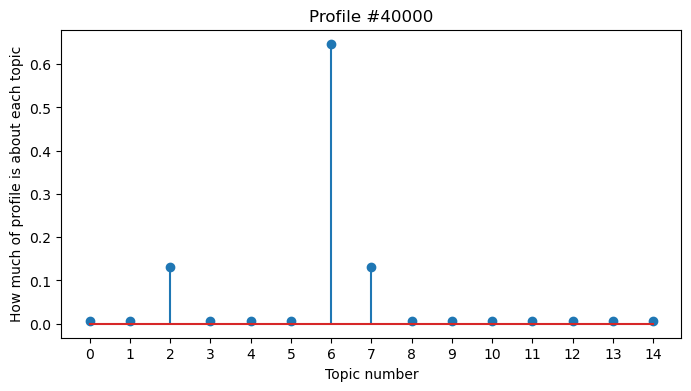

"a hiker, camper, conversationalist, tennis player (sort of).\n\ni like funny and serious people and i'm pretty good at scrabble."

In [40]:
pid = 40000
visualize_profile(profile_topics, pid, num_topics) # visualizing the topic distribution for the profile with ID pid.


### NEW
documents[pid]

<div class="alert-info">
    
#### Short Answer No.7

- Does the topic classification make sense to you? If so, which of the words in the example printed above are the most representitave of each of the topics? (3-5 sentences)
    
- Do your topic names match what you are seeing in the text? 
- Did any of your interpretations change after reading some profiles? (You would do so by changing pid and create several different charts. Then, based on the result, conclude if you want to make any changes to your topic names) 
    - If you need to update your topic names, do so here.
    
</div>

🤔 **Write your response here:**
...

## Section 5: Topic Quality
Let's see how good the topics we found are.

### Step 1: See if the topics are each about different things.
We want each topic to be about something different than the other topics. We can check this by comparing the words in each topic to the words in all the others. How to interpret:
- Each square shows how similar two topics are. Darker means more similar, and lighter means more different.
- The square in the very top left shows how similar topic 0 is to topic 0 (i.e. how similar it is to itself). 
- The square next to it in the top row shows how similar topic 0 is to topic 1, and so on. 
- For any two topics, you can see how similar they are by finding their numbers on the edges and seeing where they intersect.

<Figure size 640x480 with 0 Axes>

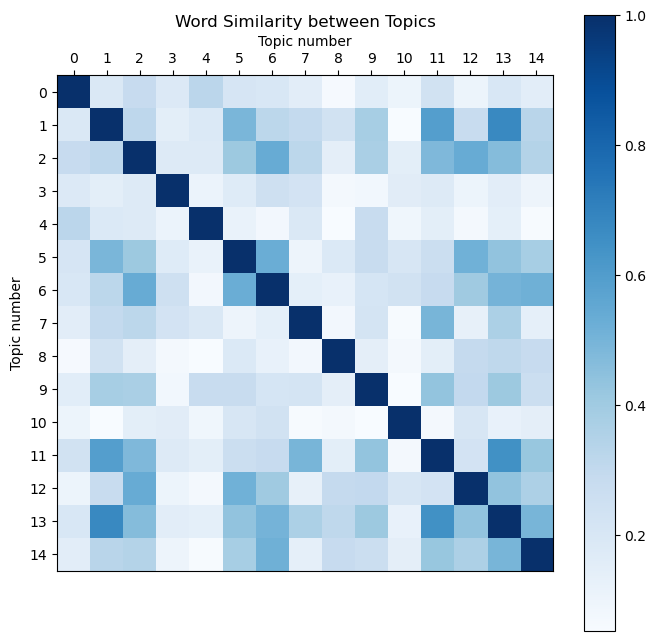

In [41]:
def plot_topics(components):
    sim = cosine_similarity(components)
    blue_matrix(sim, xl='Topic number', yl='Topic number',
                t = 'Word Similarity between Topics')  # heatmap
    return

plot_topics(lda_topics)

### Step 2: See if different topics show up in different profiles
The point is to tell profiles apart based on what topics they're about, so we need to check whether the topics appear in different profiles.
- This shows us something that looks similar to the topic similarity we saw before, but this time:
    - We **don't** compare topics based on which words they use
    - We **do** compare topics based on how often they appear in the same profile as one another

<Figure size 640x480 with 0 Axes>

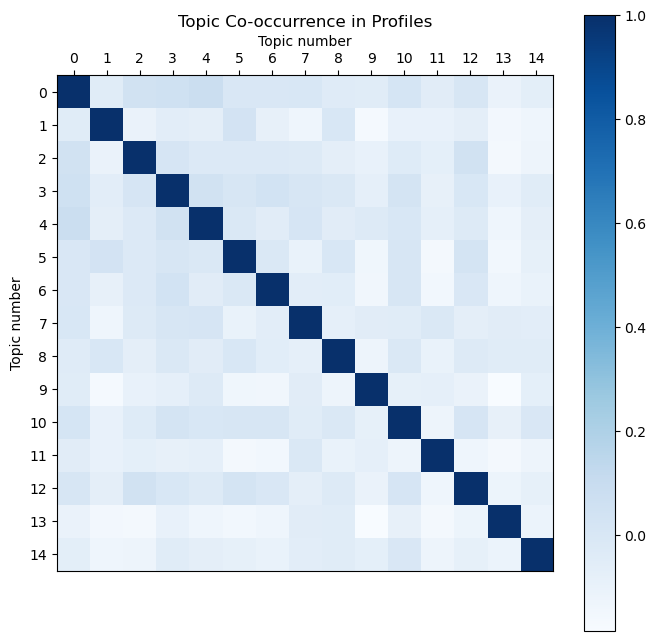

In [42]:
# Flatten the topic distributions for each profile into a matrix
profile_topics_flattened = np.array([np.array([t[1] for t in profile]) for profile in profile_topics])

# Convert to DataFrame and compute correlation
def topic_cooccurance(topics):
    co = pd.DataFrame(topics).corr()
    blue_matrix(co, xl='Topic number', yl='Topic number', t='Topic Co-occurrence in Profiles')

# Call the function with the flattened topic matrix
topic_cooccurance(profile_topics_flattened)


#### Note that the topics are mostly uncorrelated. 
- The cells in the figure above are mostly very light blue
- This doesn't mean that, for instance, topic 1 and 2 never show up in the same profile.
- It does mean, however, that seeing any particular topic doesn't mean we're especially likely to also see any other topic.

<div class="alert-info">
    
#### Short Answer No.8
- Why is the diagonal line so dark? (1-2 sentences)

- Would you say that this topic classification result is good? Why? (explain in 1-3 sentences)

- Do you think that the two figures above are sufficient to conclude that the topic quality is perfect? Why? (3-5 sentences)

</div>

🤔 **Write your response here:**
....

## Section 6: Topic Popularity

#### Helper functions to visualize and compare topics
- Run this code and scroll down. The details of how it works aren't our focus right now.

In [43]:
def common_topics_bars(profile_topics):
    df = pd.DataFrame([{t[0]: t[1] for t in topics} for topics in profile_topics])
    
    popularity = df.mean().rename_axis('Topic')
    
    popularity = popularity.sort_values(ascending=False)
    
    popularity.plot.bar(title='Topic Popularity')
    plt.xlabel('Topic')
    plt.ylabel('Average Probability')
    plt.show()
    return

def rank_groups(data, trait, topic):
    groups = data[trait].value_counts().index.values
    result = {}
    
    # Rank groups by their mean for the specific topic
    for g in groups:
        result[g] = data[data[trait] == g][topic].mean()
    
    r = pd.DataFrame.from_dict(result, orient='index')
    r.columns = [topic]
    r = r.sort_values(by=topic, ascending=False)
    
    return r.round(3)

def top_topics(data, trait, value, n_top_topics=3, distinctive=False):
    topics = [col for col in data if col.startswith('topic_')]
    vals = {}
    means = {}
    if distinctive:
        for t in topics:
            means[t] = data[t].mean()
    else:
        for t in topics:
            means[t] = 1
    
    data = data[data[trait] == value]
    
    for t in topics:
        vals[t] = data[t].mean() / means[t]
    vals = pd.DataFrame.from_dict(vals, orient='index')    
    vals = vals.sort_values(by=0, ascending=False).head(n_top_topics)

    return list(vals.index.values)

### Overall most common topics

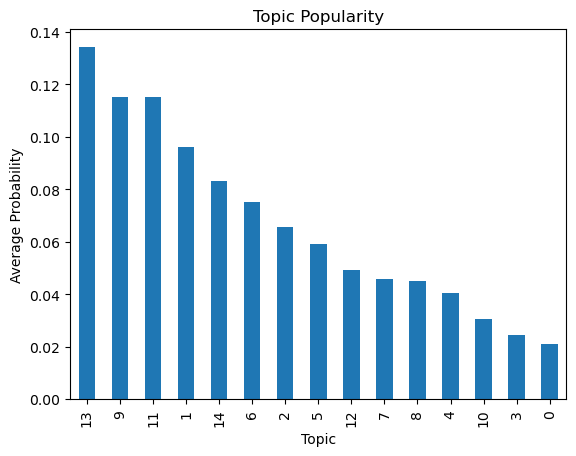

In [44]:
common_topics_bars(profile_topics)

### Who is a topic most popular with?

#### Step 1: Merge our information about topics with our information about people

In [45]:
profile_topics_prob = [[prob for _, prob in doc] for doc in profile_topics]
topic_info = pd.DataFrame(profile_topics_prob).add_prefix('topic_')
together = profiles.merge(topic_info, left_index=True, right_index=True)
together.head()

,age_group,age,body,alcohol_use,drug_use,edu,race_ethnicity,height_group,industry,kids,...,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,20,22,overweight,yes,no,HS,multiple,over_6,other,no,...,0.059550,0.409010,0.000641,0.000641,0.000641,0.000641,0.000641,0.063567,0.071916,0.000641
1,30,35,average,yes,yes,unknown,White,under_6,other,no,...,0.072061,0.102069,0.036455,0.001452,0.001452,0.001452,0.263081,0.001452,0.397122,0.116148
2,30,38,thin,yes,yes,Grad_Pro,NaN,under_6,NaN,no,...,0.291722,0.140776,0.000667,0.000667,0.041263,0.125835,0.000667,0.065441,0.000667,0.275337
3,20,23,thin,yes,yes,HS,White,under_6,education,no,...,0.013335,0.013335,0.013335,0.013335,0.598057,0.013335,0.013335,0.013335,0.013335,0.013335
4,20,29,fit,yes,no,BA,multiple,under_6,creative,no,...,0.002900,0.002900,0.002900,0.002900,0.002900,0.156483,0.002900,0.002900,0.002900,0.670909


#### Step 2: See the groups that have the most text about a given topic
- The numbers here show how much of a profile, on average, is about a specific topic. For example, if you don't have a pet, you probably wouldn't be writing about your pet (topic X). 

#### Play around with the code in the next few cells:
- Pick 3 of the traits we have data for. Here are the options (information we know about users from their profiles):
    - `age_group` categories: ['10', '20', '30', '40', '50']
    - `body` categories: ['average', 'fit', 'thin', 'overweight', 'unknown']
    - `alcohol_use` categories: ['yes', 'no']
    - `drug_use` categories: ['yes', 'no']
    - `edu` (highest degree completed) categories: ['`<HS`', 'HS', 'BA', 'Grad_Pro', 'unknown'] 
    - `race_ethnicity` categories: ['Asian', 'Black', 'Latinx', 'White', 'multiple', 'other']
    - `height_group` (whether someone is over or under six feet tall) categories: ['under_6', 'over_6']
    - `industry` (what field they work in) categories: ['STEM', 'business', 'education', 'creative', 'med_law', 'other'] 
    - `kids` (whether they have children) categories: ['yes', 'no']
    - `orientation` categories: ['straight', 'gay', 'bisexual']
    - `pets_likes` (what pets they like) categories: ['both', 'dogs', 'cats', 'neither']
    - `pets_has` (what pets they have) categories: ['both', 'dogs', 'cats', 'neither']
    - `pets_any` (whether they have pets or not) categories: ['yes', 'no']
    - `religion` categories: ['christianity', 'catholicism', 'judaism', 'buddhism', 'none', 'other'] 
    - `sex` categories: ['m', 'f']
    - `smoker` categories: ['yes', 'no']
    - `languages` categories: ['multiple', 'English_only'] 
- Change the topics and values in the code in the next few cells to explore how the trait you chose relates to the topics.
    
<div class="alert-info">
    
#### Short Answer No.9

- Before you run the code, predict what will the result be (1-2 sentences)

- Write down which traits you chose to look at, and what you learned about different groups of people from the topics they used. What topics do they have in common? What topics make them different? Does this make sense given the groups? Why or why not? Remember: we interpreted the topics above, so explain your findings in terms of content, not just topic numbers. (1-2 paragraphs)

- Does the actual result match your prediction? 

In [46]:
rank_groups(together, trait='edu', topic='topic_5') ## we use this as an example, and ask students to find 3 more

,topic_5
HS,0.061
Grad_Pro,0.059
unknown,0.059
BA,0.059
<HS,0.049


#### Step 3: See the topics that are most common for a given group
- This example shows most common topics for different education groups.
- You can change the arguments to compare different groups.

In [47]:
#show most popular topics for High School graduates
top_topics(data=together, trait='edu', value='HS', n_top_topics=3)

['topic_13', 'topic_11', 'topic_9']

In [48]:
#show most popular topics for High School graduates
top_topics(data=together, trait='edu', value='BA', n_top_topics=3)

['topic_13', 'topic_9', 'topic_11']

#### Step 4: See the topics that distinguish a group from other groups
- This example shows most distinctive topics for different education levels.
- You can change the arguments to compare different groups

In [49]:
top_topics(data=together, trait='edu', value='HS', n_top_topics=3, distinctive=True)

['topic_4', 'topic_0', 'topic_8']

In [50]:
top_topics(data=together, trait='edu', value='Grad_Pro', n_top_topics=3, distinctive=True)

['topic_8', 'topic_4', 'topic_13']

🤔 **Write your response here:**
....

# Section 7: NMF Topic Model
- NMF is an alternative to LDA
- NMF stands for Non-Negative Matrix Factorization. 

### Expand for more on how NMF works

- `Factoring` is something you may have done in math class before, for example:
    - $ 10 $ can be factored as $ 2 \times 5 $
    - $ x^2+3x+2 $ can be factored as $ (x+2)(x+1)$
- When we convert the text into numbers for the computer, it gets stored as something called a `matrix`.
    - The matrix is `non-negative` because we can't have negative numbers of words: all the word counts are zero or more.
- It is not important right now how exactly we find factors for these matrices, but if you're curious, you can learn more about it in a Linear Algebra class.
- It turns out that finding factors for text is a really good way of finding topics. This makes sense intuitively: factors are simple things we can combine to get the more complicated output, and topics are simple things people combine to write profiles.
- [Learn more](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization#Text_mining) about NMF.

### Step 1: Convert text to numbers the computer understands
- NMF takes "tf-idf vectors" as input. Tf-idf stands for "text frequency - inverse document frequency." 
    - Text frequency is the same as the count vectors we used for LDA above: how often does each word appear in the text?
    - Inverse document frequency means we divide ("inverse") by the number of documents the word is in. (If everyone uses the word, it isn't very helpful for figuring out what makes people different. So this measurement looks for words that are used a lot in some documents, and not at all in others.)

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

print("Vectorizing text by TF-IDF...")
tfidf_text = tfidf_vectorizer.fit_transform(documents)

tmp = tfidf_text.get_shape()
print("Our transformed text has", tmp[0], "rows and", tmp[1], "columns.")

Vectorizing text by TF-IDF...
Our transformed text has 53396 rows and 1000 columns.


#### The features are mostly the same as count vectors, because they are just the common words in the text

In [52]:
tfidf_words = tfidf_vectorizer.get_feature_names_out()
print("The first few words (alphabetically) are:\n", tfidf_words[:20])

The first few words (alphabetically) are:
 ['10' '11' '12' '15' '20' '30' 'ability' 'able' 'abroad' 'absolutely'
 'act' 'active' 'activities' 'activity' 'actually' 'add' 'admit'
 'adventure' 'adventures' 'adventurous']


#### The values are different: the counts have been divided by the documents they show up in

In [53]:
n = 4

print('Profile text:\n', documents[n])
print('\nTF-IDF vector:')

def show_vector(x, words):
    rows,cols = x.nonzero()
    for row,col in zip(rows,cols):
        print(words[col], '\t', x[row,col].round(2))
        
show_vector(tfidf_text[n], words=tfidf_words)

Profile text:
 hey how's it going? currently vague on the profile i know, more to
come soon. looking to meet new folks outside of my circle of
friends. i'm pretty responsive on the reply tip, feel free to drop
a line. cheers.

TF-IDF vector:
free 	 0.25
feel 	 0.22
outside 	 0.26
folks 	 0.36
meet 	 0.2
soon 	 0.31
come 	 0.25
profile 	 0.26
currently 	 0.26
going 	 0.17
hey 	 0.3
pretty 	 0.19
friends 	 0.15
new 	 0.14
looking 	 0.16
line 	 0.33
know 	 0.17


### Step 2: Build a topic model using NMF

- NMF is faster than LDA and often works a little better for small documents like we have here.

In [54]:
import sklearn
from sklearn.decomposition import NMF

sklearn_major_ver = int(sklearn.__version__.split('.')[0])

if (sklearn_major_ver < 1):
    model = NMF(n_components=ntopics, alpha=.1, l1_ratio=.5, init='nndsvd', random_state= 7)
else:
    # after sklearn v1.0, parameter alpha was removed, alpha_W and alpha_H with different approach.  
    model = NMF(n_components=ntopics, alpha_W=.0001, alpha_H='same', l1_ratio=.5, init='nndsvd', random_state= 7)

print('Performing NMF on vectors...')
nmf = model.fit(tfidf_text)
nmf_topics = nmf.components_

print('Done!')

Performing NMF on vectors...
Done!


### Step 3: Show our topics with the top words in each

In [55]:
def describe_NMF_topic(topic, feature_names, n_words=10):
    words = []
    # sort the words in the topic by importance
    topic = topic.argsort() 
    # select the n_words most important words
    topic = topic[:-n_words - 1:-1]
    # for each important word, get it's name (i.e. the word) from our list of names
    for i in topic:
        words.append(feature_names[i])
    # print the topic number and its most important words, separated by spaces
    return " ".join(words)


def display_NMF_topics(components, feature_names, n_words=10):
    # loop through each topic (component) in the model; show its top words
    for topic_idx, topic in enumerate(components):
        print("Topic {}:".format(topic_idx), 
              describe_NMF_topic(topic, feature_names, n_words))
    return
    
display_NMF_topics(nmf_topics, tfidf_words, nshow)

Topic 0: time people don things really friends know enjoy think person
Topic 1: bay area moved years sf east ago born school grew
Topic 2: just ask know moved want message meet really trying say
Topic 3: new people meet meeting things trying places friends try city
Topic 4: like things don movies stuff play people watch feel fun
Topic 5: im dont lol chill guy thats person laid nice kinda
Topic 6: love laugh travel outdoors family food cook dance sports hiking
Topic 7: life live enjoy fullest share enjoying living simple short loving
Topic 8: san francisco city moved living years born raised lived diego
Topic 9: looking fun guy loving meet girl nice friends relationship share
Topic 10: good food conversation time humor company sense enjoy wine friends
Topic 11: going easy guy enjoy person laid pretty fun movies friends
Topic 12: work hard play working time live job sf company school
Topic 13: ve lived years got told past seen traveled spent far
Topic 14: music art live movies listening 

### Step 4: Compare topics to each other
We can compare topics visually by plotting the similarity of each topic's chosen words to each other topic.

<Figure size 640x480 with 0 Axes>

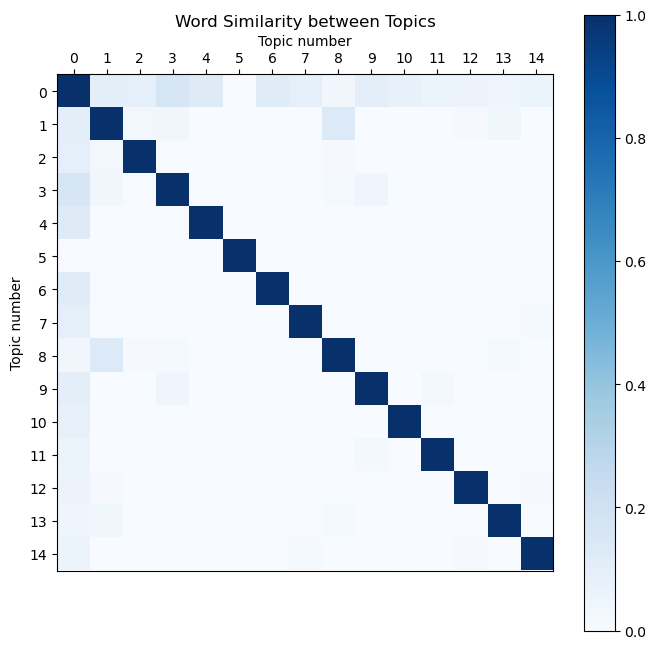

In [56]:
plot_topics(nmf_topics)

#### Examine the words that make two topics similar or different
We can also compare two topics to each other by looking at words that are common in both, or words that are common in one but not the other. Try changing topic_a and topic_b to different topic numbers.

In [57]:
def find_intersection(idxa, idxb, n):
    a = set()
    b = set()
    both = set()
    i = 0
    while len(both) < n:
        a.add(idxa[i])
        b.add(idxb[i])
        both = a.intersection(b)
        i += 1
    return list(both)

def compare_topic_words(topics, a, b, words, how='overlap', n_words=nshow):
    b_sort = False
    if how == 'difference':
        b_sort = True
    
    dfa = pd.DataFrame(topics, columns=words).T
    idxa = dfa.sort_values(by=a, ascending=False).index.values
    idxb = dfa.sort_values(by=b, ascending=b_sort).index.values
    both = find_intersection(idxa, idxb, n=n_words)
    
    out = how + ' between ' + str(a) + ' and ' + str(b) + ':'
    for w in both:
        out += ' ' + w
    print(out)
    return

topic_a = 1
topic_b = 8

compare_topic_words(nmf_topics, topic_a, topic_b, tfidf_words, n_words=nshow, how='overlap')
compare_topic_words(nmf_topics, topic_a, topic_b, tfidf_words, n_words=nshow, how='difference')
compare_topic_words(nmf_topics, topic_b, topic_a, tfidf_words, n_words=nshow, how='difference')

overlap between 1 and 8: year ago living raised moved lived college born years grew
difference between 1 and 8: outdoors running recent places pretty place past outside playing 10
difference between 8 and 1: play pictures point played planning picture playful plan poetry plus


### Step 5: Interpret these topics

<div class="alert-info">
    
#### Short Answer No.10
    
- This part is for you to do: code can't do it for you.
- Look at the list of important words for each topic, and think about these questions.
    - What do the words have in common?
    - What could someone write that would use most of those words?
    - What does this topic seem to be about?
- Try to come up with a short, catchy name for each topic.
    - For example, if the words were "san francisco city moved living born years raised lived live", you might call it "places lived" because the topic seems to be about where people currently live (San Francisco) and where they were born / raised / moved from. 
    
</div>

🤔 **Write your response here:**
....

### Step 6: Compare the topics from LDA and NMF

#### Helper function to make a graph for us

In [58]:
def plot_confusion(x, y, x_label='', y_label='', t_label = '', sort=True):
    n = x.shape[0]
    corrs = cosine_similarity(x, y)
    topic_similarity = pd.DataFrame(corrs)
    new_order=None
    
    if sort:
        matches = []
        pairs = {}

        for i in range(n):
            for j in range(n):
                tmp = {}
                tmp['i'] = i
                tmp['j'] = j
                tmp['match'] = corrs[i][j]
                matches.append(tmp)

        matches = pd.DataFrame(matches).sort_values(by='match', ascending=False)

        for row in matches.iterrows():
            i = row[1]['i']
            j = row[1]['j']
            if i not in pairs.keys():
                if j not in pairs.values():
                    pairs[i] = row[1]['j']

        new_order = list(range(n))
        for k in pairs.keys():
            new_order[int(k)] = int(pairs[k])

        topic_similarity = topic_similarity[new_order]

    blue_matrix(topic_similarity, xl=x_label, yl=y_label,
                t = t_label,
                x_labels=new_order)
    return

#### See how similar the words in each topic from LDA are to the words in each topic from NMF
- The NMF topics are along the X axis and the LDA are along the Y axis.

<Figure size 640x480 with 0 Axes>

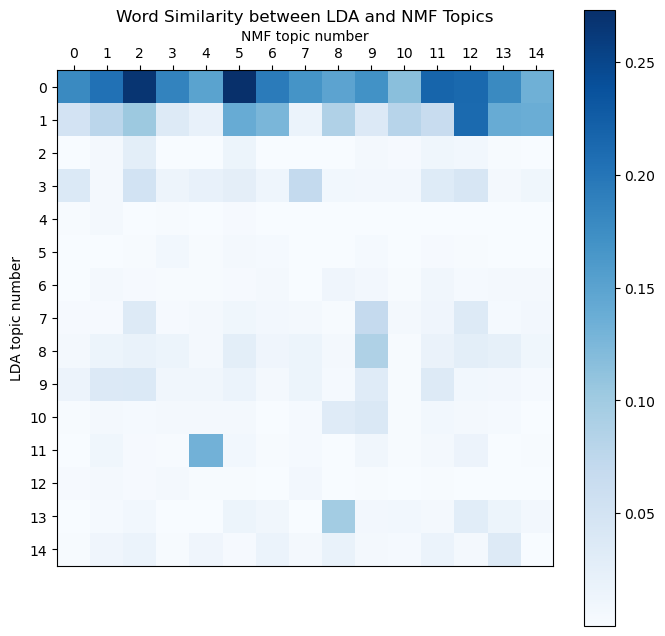

In [59]:
x_common = nmf_topics[:, :1000]
y_common = lda_topics[:, :1000]

plot_confusion(x = x_common, y = y_common, x_label='NMF topic number',
               y_label='LDA topic number',
               t_label = 'Word Similarity between LDA and NMF Topics',
               sort=False)


#### We can also sort the topics so that the most similar ones are aligned

<Figure size 640x480 with 0 Axes>

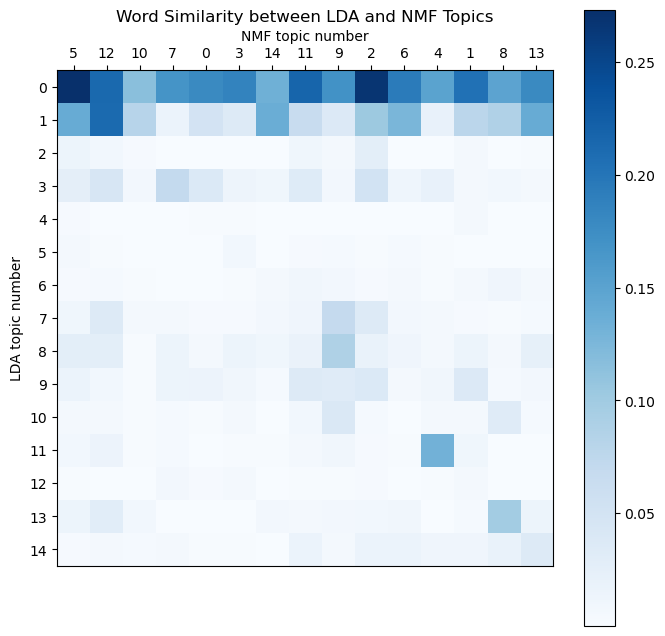

In [60]:
x_common = nmf_topics[:, :1000]
y_common = lda_topics[:, :1000]

plot_confusion(x = x_common, y = y_common, x_label='NMF topic number',
               y_label='LDA topic number',
               t_label = 'Word Similarity between LDA and NMF Topics',
               sort=True)

<div class="alert-info">
    
#### Short Answer No.11

Look at the LDA and NMF topic words and the confusion matrix, and consider the following questions:
- Do any of the topics seem to be the same in both models?
- Are some topics in one model but not the other?
- Do the topics you get from one of the models make more sense than the ones you get from the other?

</div>

🤔 **Write your response here:**
....

## Section 8: What We Learned
- Two statistical methods for topic modeling
    - LDA
    - NMF
- How to think about and interpret the topics our models find
- How to compare and relate different topics
- Different ways to see the distribution of topics in profiles
- Which topics are most popular with social categories of people
- Which social categories of people discuss a topic most

<div class="alert-warning">

#### Reflection Question 1:
- How is what we learned in this lab, using topic modeling, different from what we learned in the last lab, using just word frequencies? How is it similar? Write a paragraph explaining. 
    
</div>

🤔 **Write your response here:**
....

<div class="alert-warning">

#### Reflection Question 2:
- For both the LDA and NMF models, we specified 15 topics. Now, try running the LDA with other numbers of topics.
    - If the topics seemed repetitive, you might want to try looking for fewer topics.
    - If the topics seem confusing or vague, you might want to try looking for more topics (so that they can be more specific).
- Run the code below and answer the following:
    - What different numbers of topics did you try?
    - How did your interpretations change in response to the number of topics? Were they it easier or more difficult to interpret?
    - How did topic quality change in response to the number of topics? Were topics more similar or less similar?
    
</div>

🤔 **Write your response here:**
....

#### Step 1: Decide how many topics we want to find
- We must tell LDA how many topics we want it to look for (we did this above with the `ntopics` variable).
    - We suggest picking a few values between 2-50.

In [61]:
#how many topics we want our model to find
ntopics = 2

#how many top words we want to display for each topic
nshow = 10

id2word = corpora.Dictionary(data_lemmatized)

texts = data_lemmatized

corpus = [id2word.doc2bow(text) for text in texts]

#### Step 2: Run the LDA algorithm

In [62]:
# Build LDA model
print('Performing LDA on vectors. This may take a while...')
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=ntopics, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

lda_topics = lda_model.get_topics()

print('Done!')

Performing LDA on vectors. This may take a while...
Done!


#### Step 3: Show our topics with the top words in each

In [63]:
display_topics(lda_model, n_words=10)

Topic 0: love go new enjoy life time friend work live good
Topic 1: people get know thing make life think love good want


#### Step 4: Examine the words that make two topics similar or different
- We can also compare two topics to each other by looking at words that are common in both, or words that are common in one but not the other.
- Try changing `topic_a` and `topic_b` to different topic numbers.
- Notice the `how` option will let you see either the `overlap` or `difference` between two topics
    - Notice also that the difference between topics a and b is not the same as between b and a

In [64]:
topic_a = 0
topic_b = 1

compare_topic_overlap(lda_model, topic_a, topic_b)
compare_topic_difference(lda_model, topic_a, topic_b)

Common words between Topic 0 and Topic 1:
{'life', 'love', 'good'}
Words unique to Topic 0: {'time', 'go', 'new', 'work', 'friend', 'enjoy', 'live'}
Words unique to Topic 1: {'get', 'think', 'thing', 'people', 'want', 'make', 'know'}


#### Step 5: Interpret these topics
- This part is for you to do: code can't do it for you.
- Try to come up with a short, catchy name for each topic (no writing required).

#### Step 6: Topic Quality
Let's see how good the topics we found are.

#### Step 6.1: See if the topics are each about different things.
We want each topic to be about something different than the other topics. We can check this by comparing the words in each topic to the words in all the others. How to interpret:
- Each square shows how similar two topics are. Darker means more similar, and lighter means more different.
    - Notice that some topics may be negatively correlated.
- The square in the very top left shows how similar topic 0 is to topic 0 (i.e. how similar it is to itself). 
- The square next to it in the top row shows how similar topic 0 is to topic 1, and so on. 
- For any two topics, you can see how similar they are by finding their numbers on the edges and seeing where they intersect.

<Figure size 640x480 with 0 Axes>

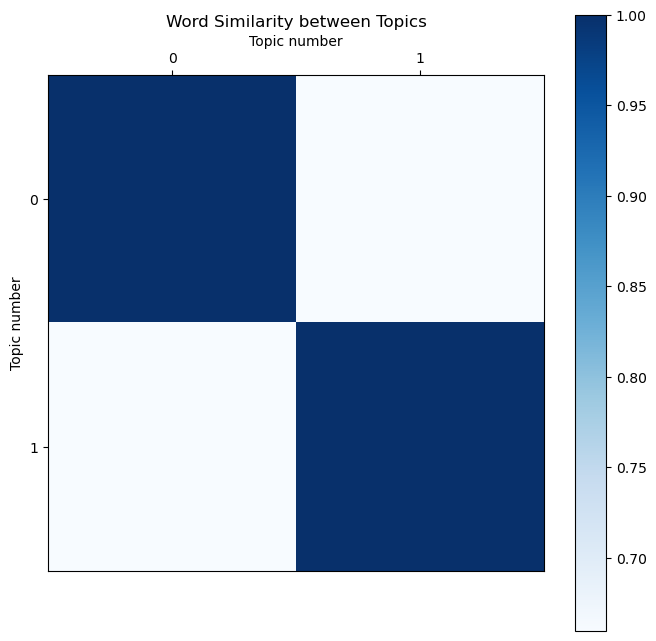

In [65]:
def plot_topics(components):
    sim = cosine_similarity(components)
    blue_matrix(sim, xl='Topic number', yl='Topic number',
                t = 'Word Similarity between Topics')
    return

plot_topics(lda_topics)

#### Step 6.2: See if different topics show up in different profiles
The point is to tell profiles apart based on what topics they're about, so we need to check whether the topics appear in different profiles.
- This shows us something that looks similar to the topic similarity we saw before, but this time:
    - We **don't** compare topics based on which words they use
    - We **do** compare topics based on how often they appear in the same profile as one another

In [66]:
profile_topics = [lda_model.get_document_topics(bow, minimum_probability=0) for bow in corpus]
profile_topics_flattened = np.array([np.array([t[1] for t in profile]) for profile in profile_topics])

<Figure size 640x480 with 0 Axes>

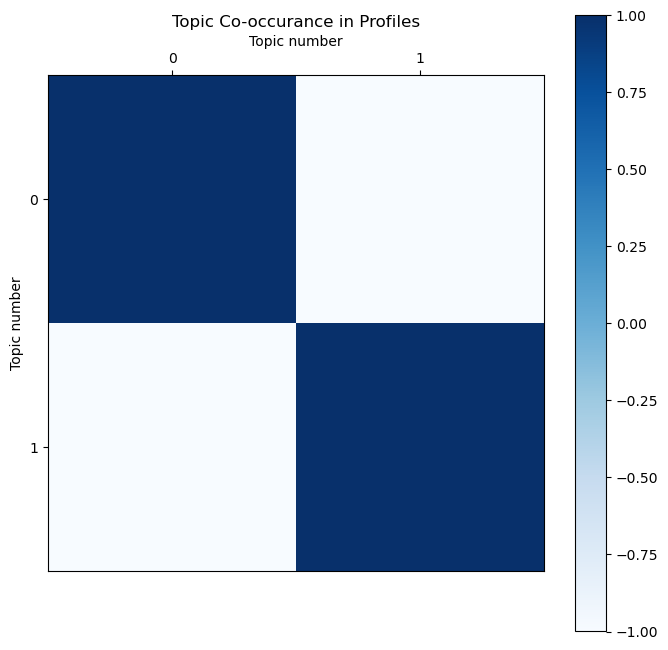

In [67]:
def topic_cooccurance(topics):
    co = pd.DataFrame(topics).corr()
    blue_matrix(co, xl='Topic number', yl='Topic number',
               t = 'Topic Co-occurance in Profiles')

topic_cooccurance(profile_topics_flattened)